In [17]:
%matplotlib inline

In [18]:
import torchvision
from torchvision.datasets import ImageFolder
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset
from PIL import Image
import os
import collections
import time
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
import numpy as np
from torch.utils.tensorboard import SummaryWriter

In [5]:
#Apply transform

transform = transforms.Compose([
      # Resize images to 32x32 pixels
    transforms.ToTensor(),    
    transforms.Resize((192,192),antialias=True),# Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values
])
train_dir = './Dataset/train'

classes = [d for _,d,_ in os.walk(train_dir) if len(d)][0]
labels_map = {classes[k]:k for k in range(0,len(classes))}
len(classes)
imbalance = collections.defaultdict(int)
for dirpath, dirnames, filenames in os.walk(train_dir):
    for f in filenames:
        if not f.startswith('.'):
            full_path = os.path.join(dirpath, f)  # Construct full path once
            imbalance[full_path.split('/')[-2]] += 1

print(sorted(imbalance.items(), key=lambda k:k[1], reverse=True))


[('Acne and Rosacea Photos', 840), ('Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 322), ('Light Diseases and Disorders of Pigmentation', 299), ('Warts Molluscum and other Viral Infections', 248), ('Tinea Ringworm Candidiasis and other Fungal Infections', 122), ('Vascular Tumors', 101), ('Atopic Dermatitis Photos', 100), ('Lupus and other Connective Tissue diseases', 90), ('Systemic Disease', 81), ('Seborrheic Keratoses and other Benign Tumors', 80), ('Cellulitis Impetigo and other Bacterial Infections', 65), ('Poison Ivy Photos and other Contact Dermatitis', 62), ('Psoriasis pictures Lichen Planus and related diseases', 62), ('Herpes HPV and other STDs Photos', 40), ('Eczema Photos', 35), ('Melanoma Skin Cancer Nevi and Moles', 24), ('Exanthems and Drug Eruptions', 20), ('Vasculitis Photos', 15), ('Urticaria Hives', 3)]


In [11]:
class SkinCondition(Dataset):
    def __init__(self, data_directory, transform=None):
        self.data_directory = data_directory
        self.transform = transform
        self.filenames = []
        self.labels = []
        for dirpath, dirnames, filenames in os.walk(data_directory):
            for f in filenames:
                if not f.startswith('.'):
                    full_path = os.path.join(dirpath, f)  # Construct full path once
                    self.filenames.append(full_path) 
                    self.labels.append(labels_map[full_path.split('/')[-2]])
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        img_path = self.filenames[idx]  
        image = Image.open(img_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [12]:
trainset = SkinCondition(data_directory='./Dataset/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
                                          shuffle=True, num_workers=0)
print("Length of training data:", len(trainset))

testset = SkinCondition(data_directory='./Dataset/test', transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=5,
                                         shuffle=False, num_workers=0)
print("Length of test data:", len(testset))


Length of training data: 2609
Length of test data: 895


Let us show some of the training images, for fun.



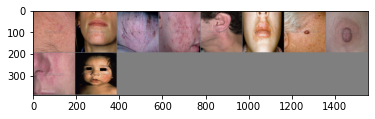

Acne and Rosacea Photos Tinea Ringworm Candidiasis and other Fungal Infections Atopic Dermatitis Photos Acne and Rosacea Photos


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolutional Neural Network


Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [13]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, name=None):
        super(Net, self).__init__()
        if name:
            self.name = name
        self.dense = 16 * 45 * 45
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        #add dropout to prevent overfitting
        self.dropout = nn.Dropout(p=0.5)  
        self.fc1 = nn.Linear(self.dense, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(trainset.labels))
        
        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.dense)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net(name='LetNet5')

LetNet5: total params: 4123873


In [15]:
def train(net, trainloader, epochs=10):
    start = time.time()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    losses = []
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10))
                losses.append(running_loss / 10)
                running_loss = 0.0

    print('Finished Training')

    end = time.time()
    print('training time ', end-start)
    return losses

In [16]:
def plot_losses(losses):
    X = range(1,len(losses)+1)
    plt.plot(X,losses)

In [17]:
def test(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(correct,total)
    print('Accuracy of the network on the 895 test images: %d %%' % (
        100 * correct / total))

In [18]:
epochs=10
losses = train(net, trainloader, epochs)


[1,    10] loss: 3.039
[1,    20] loss: 3.101
[1,    30] loss: 2.642
[1,    40] loss: 2.331
[1,    50] loss: 2.679
[1,    60] loss: 2.460
[1,    70] loss: 2.595
[1,    80] loss: 2.435
[1,    90] loss: 2.391
[1,   100] loss: 2.481
[1,   110] loss: 2.219
[1,   120] loss: 2.788
[1,   130] loss: 2.419
[1,   140] loss: 2.191
[1,   150] loss: 2.302
[1,   160] loss: 2.318
[1,   170] loss: 2.289
[1,   180] loss: 2.311
[1,   190] loss: 2.188
[1,   200] loss: 2.166
[1,   210] loss: 2.272
[1,   220] loss: 2.131
[1,   230] loss: 2.526
[1,   240] loss: 2.356
[1,   250] loss: 2.468
[1,   260] loss: 2.287
[2,    10] loss: 2.398
[2,    20] loss: 2.561
[2,    30] loss: 2.324
[2,    40] loss: 2.392
[2,    50] loss: 2.452
[2,    60] loss: 2.278
[2,    70] loss: 2.359
[2,    80] loss: 2.255
[2,    90] loss: 2.229
[2,   100] loss: 2.197
[2,   110] loss: 2.311
[2,   120] loss: 2.330
[2,   130] loss: 2.274
[2,   140] loss: 1.996
[2,   150] loss: 2.419
[2,   160] loss: 2.256
[2,   170] loss: 2.195
[2,   180] 

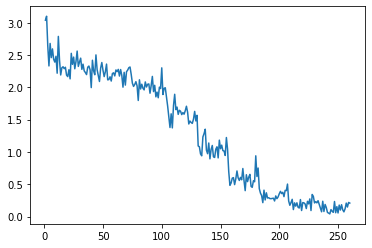

In [19]:
plot_losses(losses)

In [20]:
test(net, testloader)

486 895
Accuracy of the network on the 895 test images: 54 %


That looks way better than chance, which is 5% accuracy (randomly picking
a class out of 19 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [21]:
class_correct = list(0. for i in range(20))
class_total = list(0. for i in range(20))
classes_test = [d for _,d,_ in os.walk('./Dataset/test') if len(d)][0]

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(5):
            label = labels[i]
            class_correct[label] += int(c[i].item())
            class_total[label] += 1



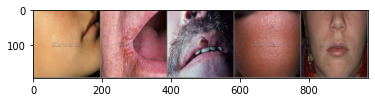

GroundTruth:  Atopic Dermatitis Photos
GroundTruth:  Tinea Ringworm Candidiasis and other Fungal Infections
GroundTruth:  Seborrheic Keratoses and other Benign Tumors
GroundTruth:  Acne and Rosacea Photos
GroundTruth:  Acne and Rosacea Photos


IndexError: list index out of range

In [22]:
testloader = torch.utils.data.DataLoader(testset, batch_size=5,
                                         shuffle=True)

dataiter = iter(testloader)
images, labels = next(dataiter)
# print images
img_grid = torchvision.utils.make_grid(images)

imshow(img_grid)
for j in range(5):
    print('GroundTruth: ', ''.join('%5s' % classes[labels[j]]))
    
outputs = net(images)

_, predicted = torch.max(outputs, 1)
for j in range(5):
    print('Predicted: ', ''.join('%5s' % classes[predicted[j]]))


In [23]:
writer = SummaryWriter('runs/ai-derm')
writer.add_image('acne_images', img_grid)


In [24]:
writer.add_graph(net, images)

In [ ]:
accuracy = collections.defaultdict(float)
for i in range(len(classes_test)):
    accuracy[classes[i]] = 100 * class_correct[i] / class_total[i]

for k,v in sorted(accuracy.items(), key=lambda k: k[1], reverse=True):
    print('Accuracy of %5s : %2d %%' % (
        k, v))

This is consistent with the imbalance of data in the above classes. 